In [14]:
import torch
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from DatasetFetcher import DatasetFetcher
from project1_model import ResNet, BasicBlock

In [15]:
# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
# Fetching Dataset
df = DatasetFetcher(dataset="CIFAR10", batch_size=64)
df.addHorizontalFlipping()
df.addRandomCrop(size=32, padding=3)
df.addNormalizer()
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
for x, y in trainLoader:
    print(x.shape)
    break

torch.Size([64, 3, 32, 32])


In [18]:
# Get Model
model = ResNet(BasicBlock, 42, 4, [2, 2, 2, 2])
model = model.to(device)
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,176
       BatchNorm2d-2           [-1, 42, 32, 32]              84
            Conv2d-3           [-1, 42, 32, 32]          15,918
       BatchNorm2d-4           [-1, 42, 32, 32]              84
            Conv2d-5           [-1, 42, 32, 32]          15,918
       BatchNorm2d-6           [-1, 42, 32, 32]              84
        BasicBlock-7           [-1, 42, 32, 32]               0
            Conv2d-8           [-1, 42, 32, 32]          15,918
       BatchNorm2d-9           [-1, 42, 32, 32]              84
           Conv2d-10           [-1, 42, 32, 32]          15,918
      BatchNorm2d-11           [-1, 42, 32, 32]              84
       BasicBlock-12           [-1, 42, 32, 32]               0
           Conv2d-13           [-1, 84, 16, 16]          31,836
      BatchNorm2d-14           [-1, 84,

In [19]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer) 
lossFunction = torch.nn.CrossEntropyLoss()
learningRate = 0.1
weightDecay = 0.0001
#optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learningRate, weight_decay=weightDecay)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [20]:
# Setting up training
EPOCHS=30
globalBestAccuracy = 0.0
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [21]:
# Training
for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model.train()
            optimizer.zero_grad()
        else:
            loader = testLoader
            model.eval()
        runningLoss = 0.0
        runningCorrects = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = lossFunction(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            runningLoss = loss.item()*images.size(0)
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))

  3%|▎         | 1/30 [00:37<18:18, 37.86s/it]

Training Loss : 0.0005100955200195312, Testing Loss : 0.001979728126525879, Training Accuracy : 0.33848, Testing Accuracy : 0.4148


  7%|▋         | 2/30 [01:15<17:35, 37.70s/it]

Training Loss : 0.0006461790466308594, Testing Loss : 0.0014862919807434082, Training Accuracy : 0.4204, Testing Accuracy : 0.4636


 10%|█         | 3/30 [01:52<16:53, 37.52s/it]

Training Loss : 0.00046424304962158205, Testing Loss : 0.0015334678649902343, Training Accuracy : 0.45958, Testing Accuracy : 0.5048


 13%|█▎        | 4/30 [02:30<16:15, 37.53s/it]

Training Loss : 0.0004321783447265625, Testing Loss : 0.001714019775390625, Training Accuracy : 0.50586, Testing Accuracy : 0.5281


 17%|█▋        | 5/30 [03:07<15:36, 37.45s/it]

Training Loss : 0.0005247460174560547, Testing Loss : 0.0017134153366088866, Training Accuracy : 0.54904, Testing Accuracy : 0.5671


 20%|██        | 6/30 [03:45<14:59, 37.47s/it]

Training Loss : 0.000535313720703125, Testing Loss : 0.0017350311279296874, Training Accuracy : 0.58768, Testing Accuracy : 0.6002


 23%|██▎       | 7/30 [04:22<14:20, 37.41s/it]

Training Loss : 0.000545429573059082, Testing Loss : 0.0021924041748046874, Training Accuracy : 0.6061, Testing Accuracy : 0.6223


 27%|██▋       | 8/30 [04:59<13:42, 37.39s/it]

Training Loss : 0.0002883005142211914, Testing Loss : 0.0018282840728759766, Training Accuracy : 0.64158, Testing Accuracy : 0.6482


 30%|███       | 9/30 [05:37<13:04, 37.35s/it]

Training Loss : 0.00017438884735107422, Testing Loss : 0.002238276290893555, Training Accuracy : 0.65556, Testing Accuracy : 0.6408


 33%|███▎      | 10/30 [06:14<12:26, 37.34s/it]

Training Loss : 0.00034697311401367186, Testing Loss : 0.0016193313598632812, Training Accuracy : 0.67024, Testing Accuracy : 0.6727


 37%|███▋      | 11/30 [06:51<11:49, 37.33s/it]

Training Loss : 0.0005800125885009766, Testing Loss : 0.0019743904113769532, Training Accuracy : 0.68792, Testing Accuracy : 0.6956


 40%|████      | 12/30 [07:28<11:11, 37.30s/it]

Training Loss : 0.0002855013465881348, Testing Loss : 0.001454323673248291, Training Accuracy : 0.71478, Testing Accuracy : 0.7129


 43%|████▎     | 13/30 [08:06<10:33, 37.27s/it]

Training Loss : 0.00035975807189941406, Testing Loss : 0.0010300694465637207, Training Accuracy : 0.72928, Testing Accuracy : 0.7127


 47%|████▋     | 14/30 [08:43<09:56, 37.26s/it]

Training Loss : 0.00013248950004577636, Testing Loss : 0.001110787296295166, Training Accuracy : 0.73922, Testing Accuracy : 0.7239


 50%|█████     | 15/30 [09:20<09:18, 37.25s/it]

Training Loss : 0.0003036781692504883, Testing Loss : 0.0014666494369506835, Training Accuracy : 0.75176, Testing Accuracy : 0.7417


 53%|█████▎    | 16/30 [09:57<08:41, 37.23s/it]

Training Loss : 0.00014828417778015138, Testing Loss : 0.0009170448303222656, Training Accuracy : 0.76496, Testing Accuracy : 0.7488


 57%|█████▋    | 17/30 [10:34<08:04, 37.23s/it]

Training Loss : 9.085978507995606e-05, Testing Loss : 0.0013026683807373046, Training Accuracy : 0.77132, Testing Accuracy : 0.7616


 60%|██████    | 18/30 [11:12<07:26, 37.24s/it]

Training Loss : 0.0002072037696838379, Testing Loss : 0.0015457345008850097, Training Accuracy : 0.78468, Testing Accuracy : 0.7647


 63%|██████▎   | 19/30 [11:49<06:49, 37.24s/it]

Training Loss : 0.00015190350532531737, Testing Loss : 0.0014920830726623535, Training Accuracy : 0.79104, Testing Accuracy : 0.7847


 67%|██████▋   | 20/30 [12:26<06:12, 37.23s/it]

Training Loss : 0.0002663117790222168, Testing Loss : 0.0009949713706970216, Training Accuracy : 0.80244, Testing Accuracy : 0.7753


 70%|███████   | 21/30 [13:03<05:34, 37.22s/it]

Training Loss : 0.00014393970489501954, Testing Loss : 0.0009393500328063965, Training Accuracy : 0.80388, Testing Accuracy : 0.7792


 73%|███████▎  | 22/30 [13:41<04:58, 37.27s/it]

Training Loss : 0.00031501142501831055, Testing Loss : 0.0008775022506713867, Training Accuracy : 0.80724, Testing Accuracy : 0.7937


 77%|███████▋  | 23/30 [14:18<04:20, 37.24s/it]

Training Loss : 0.0003225506591796875, Testing Loss : 0.001222251033782959, Training Accuracy : 0.81734, Testing Accuracy : 0.7853


 80%|████████  | 24/30 [14:55<03:43, 37.21s/it]

Training Loss : 0.0002862489891052246, Testing Loss : 0.0008974655151367187, Training Accuracy : 0.82026, Testing Accuracy : 0.7929


 83%|████████▎ | 25/30 [15:32<03:05, 37.20s/it]

Training Loss : 8.83213996887207e-05, Testing Loss : 0.0008375995635986328, Training Accuracy : 0.82444, Testing Accuracy : 0.8085


 87%|████████▋ | 26/30 [16:09<02:28, 37.20s/it]

Training Loss : 0.00035492431640625, Testing Loss : 0.0007195475578308106, Training Accuracy : 0.83198, Testing Accuracy : 0.8106


 90%|█████████ | 27/30 [16:47<01:51, 37.19s/it]

Training Loss : 0.0002964270782470703, Testing Loss : 0.0008711749076843262, Training Accuracy : 0.8359, Testing Accuracy : 0.8068


 93%|█████████▎| 28/30 [17:24<01:14, 37.17s/it]

Training Loss : 0.00012951539993286132, Testing Loss : 0.0013663233757019043, Training Accuracy : 0.83488, Testing Accuracy : 0.799


 97%|█████████▋| 29/30 [18:01<00:37, 37.18s/it]

Training Loss : 9.456218719482422e-05, Testing Loss : 0.0006064956188201905, Training Accuracy : 0.8366, Testing Accuracy : 0.8058


100%|██████████| 30/30 [18:38<00:00, 37.29s/it]

Training Loss : 0.0001528171443939209, Testing Loss : 0.0008010270118713378, Training Accuracy : 0.84598, Testing Accuracy : 0.8082


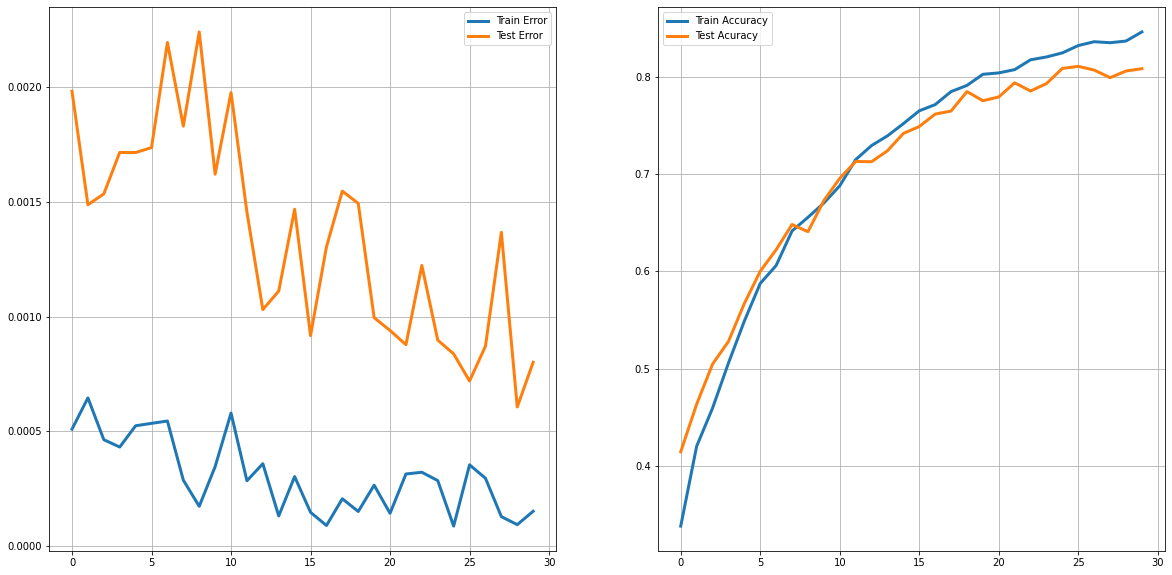

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error')
ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy')
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()
f.savefig("./trainTestCurve.png")